<a href="https://colab.research.google.com/github/MathPedroza/Matheus/blob/master/Neural%20NetWork%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**GAN**

A estrutura geral de um GAN é mostrada no diagrama acima, usando imagens MNIST como dados. A amostra latente é um vetor aleatório que o gerador usa para construir suas imagens falsas.
Isso geralmente é chamado de vetor latente e esse espaço vetorial é chamado de espaço latente . Enquanto o gerador treina, ele descobre como mapear vetores latentes para imagens reconhecíveis que podem enganar o discriminador.

Aqui será definido o número de subprocessos a serem usados ​​para o carregamento de dados
Em seguida, defina quantas amostras por lote carregar, ou seja, tamanho do lote - o tamanho do lote ideal varia de 32 a 128.
Em seguida, convertido os dados em torch.FloatTensor
depois pegamos os conjuntos de dados de treinamento
E prepare o carregador de dados que ajuda a carregar os dados no tamanho do lote mencionado acima.

In [40]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
# 1
num_workers = 0
# 2
batch_size = 64
# 3
transform = transforms.ToTensor()
# 4
train_data = datasets.MNIST(root='data', train=True,
 download=True, transform=transform)
# 5
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
 num_workers=num_workers)

Aqui obtemos um lote de imagens de treinamento. Aqui, “dataiter” irá iterar por meio de imagens e rótulos que estão presentes no conjunto de dados. Mais tarde, você obtém uma imagem do lote.

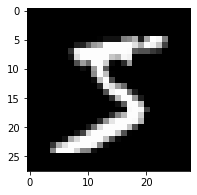

In [41]:
#1 
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
#2
img = np.squeeze(images[0])
fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

**Discriminador:**

A rede discriminadora será um classificador linear bastante típico. Para tornar essa rede um aproximador de função universal, precisaremos de pelo menos uma camada oculta, e essas camadas ocultas devem ter um atributo-chave:

Todas as camadas ocultas terão uma função de ativação Leaky ReLu aplicada às suas saídas.

Devemos usar um ReLU com vazamento para permitir que os gradientes fluam para trás através da camada sem impedimentos. Um ReLU com vazamento é como um ReLU normal, exceto que há uma pequena saída diferente de zero para valores de entrada negativos.

Aqui definimos todas as camadas lineares ocultas
Em seguida, criamos uma camada final totalmente conectada
Na função de avanço, você primeiro precisa achatar a imagem.
E, em seguida, definimos todas as camadas ocultas
Eventualmente, criando uma camada final

In [42]:
import torch.nn as nn
import torch.nn.functional as F
class Discriminator(nn.Module):


  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()

    # 1
    self.fc1 = nn.Linear(input_size, hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

    # 2
    self.fc4 = nn.Linear(hidden_dim, output_size)

    # dropout layer
    self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # 3
      x = x.view(-1, 28*28)
    # 4
    x = F.leaky_relu(self.fc1(x), 0.2)  # (input, negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    # 5
    out = self.fc4(x)


    return out


O gerador demonstrou ter o melhor desempenho com 𝑡𝑎𝑛ℎ para a saída do gerador, que dimensiona a saída para estar entre -1 e 1, em vez de 0 e 1.

Aqui definimos todas as camadas lineares ocultas
Em seguida, foi criado uma camada final totalmente conectada
Adicione uma camada de eliminação para evitar overfitting
Criamos todas as camadas ocultas na função de avanço
Eventualmente, adicione uma camada final com tanh aplicado

In [43]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
 
 # 1
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
 
 # 2
    self.fc4 = nn.Linear(hidden_dim*4, output_size)
 
 # 3
    self.dropout = nn.Dropout(0.3)
def forward(self, x):
 # 4
    x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
 # 5
    out = F.tanh(self.fc4(x))
    return out

Tamanho da imagem de entrada para discriminador (28 * 28 = 784)

Tamanho da saída do discriminador (real ou falso)

Tamanho da última camada oculta no discriminador

Tamanho do vetor latente para dar ao gerador

Tamanho da saída do discriminador (imagem gerada)
Tamanho da primeira camada oculta no gerador

In [44]:
# Hyper parâmetros do Discriminador
# 1
input_size = 784
# 2
d_output_size = 1
# 3
d_hidden_size = 32
# Hyper parâmetros do gerador
# 4
z_size = 100
# 5
g_output_size = 784
# 6
g_hidden_size = 32

In [45]:
# Instaciando o Discriminador e gerador
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)

UnboundLocalError: ignored

**Defindo as perdas:**

Para o discriminador, a perda total é a soma das perdas para imagens reais e falsas, d_loss = d_real_loss + d_fake_loss.
Lembre-se de que queremos que o discriminador produza 1 para imagens reais e 0 para imagens falsas, portanto, precisamos configurar as perdas para refletir isso.
A perda do gerador será semelhante apenas com rótulos invertidos. O objetivo do gerador é obter D (fake_images) = 1.
Nesse caso, os rótulos são invertidos para representar que o gerador está tentando enganar o discriminador fazendo-o pensar que as imagens que ele gera (falsificações) são reais!

In [46]:
# Calculando as perdas
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
    labels = torch.ones(batch_size)*0.9
    else:
    labels = torch.ones(batch_size)  # real labels = 1

    # 
    criterion = nn.BCEWithLogitsLoss()
    # calculando as perdass
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)  # fake labels = 0
    criCalculando as perdas
    loss = criterion(D_out.squeeze(), labels)
    return loss


IndentationError: ignored

In [ ]:
import torch.optim as optim
lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

O treinamento envolverá a alternância entre o treinamento do discriminador e do gerador. Usaremos nossas funções real_loss e fake_loss para nos ajudar a calcular as perdas do discriminador em todos os casos a seguir.

**Treinamento de discriminador:**

Calculando a perda do discriminador em imagens reais de treinamento
Gerar imagens falsas
Calculando a perda de discriminador em imagens falsas geradas
Some a perda real e falsa
Executando retropropagação + uma etapa de otimização para atualizar os pesos do discriminador
Gerarando imagens falsas
Calculando a perda de discriminador em imagens falsas, usando etiquetas invertidas!
Execute retropropagação + uma etapa de otimização para atualizar os pesos do gerador